# Which factors influence students’ drinking habits? 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols

df = pd.read_csv(r"C:\Users\IBML590\Desktop\Stats survey.csv",usecols=[1,4,10,11])
df.columns = df.columns.str.strip()
df.shape

(406, 4)

In [2]:
df.columns.values

array(['Your Sex?', 'What faculty does your degree fall under?',
       'How often do you go out partying/socialising during the week?',
       'On a night out, how many alcoholic drinks do you consume?'],
      dtype=object)

In [3]:
df.head()

,Your Sex?,What faculty does your degree fall under?,How often do you go out partying/socialising during the week?,"On a night out, how many alcoholic drinks do you consume?"
0,Female,Arts & Social Sciences,Only weekends,8+
1,Male,Economic & Management Sciences,Only weekends,5-Mar
2,Male,AgriSciences,2,8+
3,Male,Engineering,3,8+
4,Female,Arts & Social Sciences,Only weekends,8-May


In [4]:
dict_newcols = {"Your Sex?": "gender", "What faculty does your degree fall under?": "faculty", 
                "How often do you go out partying/socialising during the week?" : "partying", 
                "On a night out, how many alcoholic drinks do you consume?": "alcoholic_beverages"}
df_re = df.rename(dict_newcols, axis=1)
df_re.head()

,gender,faculty,partying,alcoholic_beverages
0,Female,Arts & Social Sciences,Only weekends,8+
1,Male,Economic & Management Sciences,Only weekends,5-Mar
2,Male,AgriSciences,2,8+
3,Male,Engineering,3,8+
4,Female,Arts & Social Sciences,Only weekends,8-May


In [5]:
month_fix = {'Jan': '1', 'Mar': '3', 'May':'5'}  

def fix_weird_format(val):
    if isinstance(val, str) and '-' in val:
        day, mon = val.split('-')
        if mon in month_fix:
            return f"{month_fix[mon]}-{day}"
    return val

df_re['alcoholic_beverages'] = df_re['alcoholic_beverages'].apply(fix_weird_format)
df_re.head()

,gender,faculty,partying,alcoholic_beverages
0,Female,Arts & Social Sciences,Only weekends,8+
1,Male,Economic & Management Sciences,Only weekends,3-5
2,Male,AgriSciences,2,8+
3,Male,Engineering,3,8+
4,Female,Arts & Social Sciences,Only weekends,5-8


In [6]:
alcohol_mapping = {'1-3': 2,'3-5': 4,'5-8': 6.5,'8+': 9 , '0':0}
df_re['estimated drinks'] = df_re['alcoholic_beverages'].map(alcohol_mapping)
df_re.head()

,gender,faculty,partying,alcoholic_beverages,estimated drinks
0,Female,Arts & Social Sciences,Only weekends,8+,9.0
1,Male,Economic & Management Sciences,Only weekends,3-5,4.0
2,Male,AgriSciences,2,8+,9.0
3,Male,Engineering,3,8+,9.0
4,Female,Arts & Social Sciences,Only weekends,5-8,6.5


In [7]:
def map_socializing(val):
    val = str(val).strip()
    if val.lower() == 'only weekends':
        return 1.5
    elif val == '4+':
        return 5
    elif val.isdigit():
        return int(val)
    else:
        return np.nan

df_re['party estimated'] = df_re['partying'].apply(map_socializing)
df_re.head()

,gender,faculty,partying,alcoholic_beverages,estimated drinks,party estimated
0,Female,Arts & Social Sciences,Only weekends,8+,9.0,1.5
1,Male,Economic & Management Sciences,Only weekends,3-5,4.0,1.5
2,Male,AgriSciences,2,8+,9.0,2.0
3,Male,Engineering,3,8+,9.0,3.0
4,Female,Arts & Social Sciences,Only weekends,5-8,6.5,1.5


In [8]:
df_re[['gender','faculty','partying', 'alcoholic_beverages']].describe(include='all')

,gender,faculty,partying,alcoholic_beverages
count,404,399,404,404
unique,2,8,6,5
top,Male,Economic & Management Sciences,Only weekends,5-8
freq,216,211,113,111


# How does socializing frequency influence alcohol consumption? 

In [9]:
print(df_re[['estimated drinks', 'party estimated']].describe())

       estimated drinks  party estimated
count        404.000000       404.000000
mean           5.048267         1.783416
std            2.807208         0.986634
min            0.000000         0.000000
25%            2.000000         1.000000
50%            4.000000         1.500000
75%            6.500000         2.000000
max            9.000000         5.000000


In [10]:
summary = df_re.groupby('party estimated')['estimated drinks'].agg(['count', 'mean', 'median', 'std']).sort_values(by='mean', ascending=False)
summary = summary.round(2)

print(summary)

                 count  mean  median   std
party estimated                           
5.0                 16  6.84     6.5  2.32
3.0                 63  6.19     6.5  2.66
2.0                 87  5.44     6.5  2.66
1.0                108  5.14     6.5  2.80
1.5                113  4.16     4.0  2.48
0.0                 17  2.41     0.0  3.27


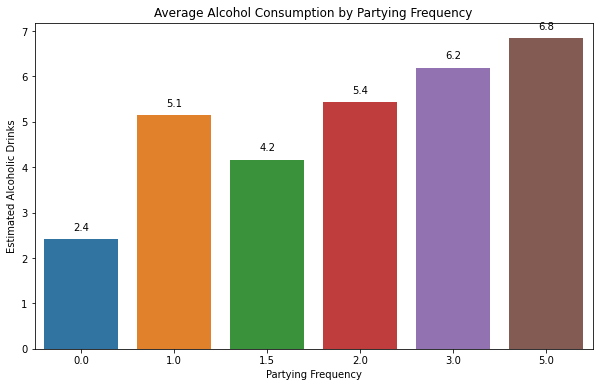

In [11]:
plt.figure(figsize=(10, 6))

ax=sns.barplot(x='party estimated', y='estimated drinks', data=df_re, ci=None)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{height:.1f}',ha='center', fontsize=10)

plt.title('Average Alcohol Consumption by Partying Frequency')
plt.xlabel('Partying Frequency')
plt.ylabel('Estimated Alcoholic Drinks')
plt.show()

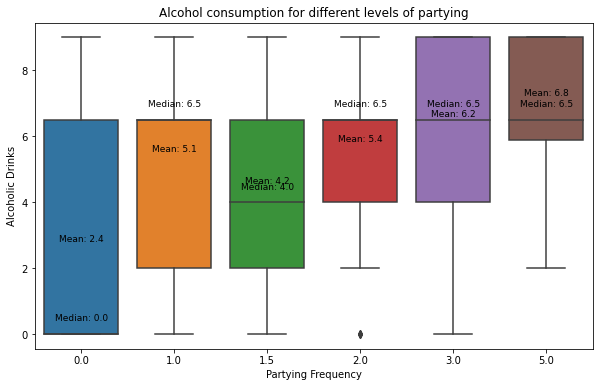

In [12]:
plt.figure(figsize=(10, 6))

ax=sns.boxplot(x='party estimated', y='estimated drinks', data=df_re)
grouped= df_re.groupby('party estimated')['estimated drinks']
medians = grouped.median()
means = grouped.mean()
positions = range(len(medians))
positions = range(len(medians))

for pos in positions:
    median = medians.iloc[pos]
    mean = means.iloc[pos]
    ax.text(pos, median + 0.4, f'Median: {median:.1f}', ha='center', color='black', fontsize=9)
    ax.text(pos, mean + 0.4, f'Mean: {mean:.1f}', ha='center', color='black', fontsize=9)
    
plt.xlabel('Partying Frequency')
plt.ylabel('Alcoholic Drinks')
plt.title('Alcohol consumption for different levels of partying')
plt.show()

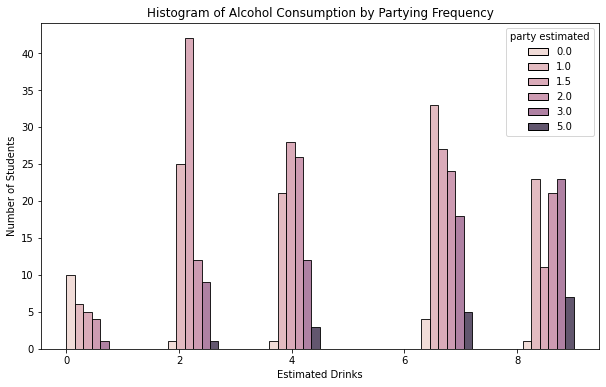

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_re, x='estimated drinks', hue='party estimated', multiple='dodge')
plt.title('Histogram of Alcohol Consumption by Partying Frequency')
plt.xlabel('Estimated Drinks')
plt.ylabel('Number of Students')
plt.show()

# Is the field of study related to the frequency of alcohol consumption per week? 

In [15]:
faculties = df_re['faculty'].dropna().unique()
grouped_data = [df_re[df_re['faculty'] == faculty]['estimated drinks'].dropna() for faculty in faculties]

f_stat, p_value = f_oneway(*grouped_data)

print("F-statistic:", f_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference in alcohol consumption between faculties.")
else:
    print("No significant difference found between faculties.")

F-statistic: 1.6787814559475598
p-value: 0.11259805334923767
No significant difference found between faculties.


# Are male students more likely to consume alcohol than female students? 

In [17]:
df_re['gender'].value_counts()

Male      216
Female    188
Name: gender, dtype: int64

In [18]:
df_re['is_male'] = df_re['gender'].str.lower().str.strip() == 'male' 
df_re['is_male'] = df_re['is_male'].astype(int)
df_re['is_male'].value_counts()

1    216
0    190
Name: is_male, dtype: int64

In [19]:
df_re['high_alcohol'] = (df_re['estimated drinks'] >= 4).astype(int)   
df_re['high_alcohol'].value_counts()                                   

1    288
0    118
Name: high_alcohol, dtype: int64

In [20]:
X = sm.add_constant(df_re['is_male'])   
y = df_re['high_alcohol']                               

model = sm.Logit(y, X)
result = model.fit()             

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.556338
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           high_alcohol   No. Observations:                  406
Model:                          Logit   Df Residuals:                      404
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                 0.07696
Time:                        22:41:08   Log-Likelihood:                -225.87
converged:                       True   LL-Null:                       -244.71
Covariance Type:            nonrobust   LLR p-value:                 8.397e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2540      0.146      1.736      0.082      -0.033       0.541
is_male        1.3892      0.